# I LASSO
 

## 1 Fonction objective et subdifferentielle

La fonction objective dans le cadre de LASSO est :
$$ f(\alpha) = 0.5 \| \big(\boldsymbol{y} - X \alpha \big) \|_2^2  + \lambda \|\alpha \|_1$$

La subdifférentielle est : 
$$\partial f(\alpha) = \{X^T(X \alpha - \boldsymbol{y})\} + \lambda \boldsymbol{s} $$ 
où $s_j = \{sign(\alpha_j)\}$ si $ \alpha_j\ne 0$ et $s_j = [-1,1]$ si $ \alpha_j = 0$, $j = 1, ...,p$

## 2 Création de données 
Importons les modules.

In [232]:
# supprime toutes les variables

from IPython import get_ipython;   
get_ipython().magic('reset -sf')

#importe les modules
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import linalg
import timeit
from numpy.random import seed
from numpy.random import rand
import numpy.matlib 

Création des données $X$ et $y$, avec un bruit gaussien ou suivant une loi de poisson.
La fonction "cre_data" prend comme argument la taille de $X$ et le booléen "poisson". Par défaut poisson $= 0$. Si l'on veut générer des données issues d'une loi de poisson il faut mettre " poisson = 1".
$X$ et $\alpha$ sont générés via un tirage aléatoire, puis par calcul, on trouve $y$.

In [233]:
def crea_data(n,p,poisson =0):

    seed(1)
    X = rand(n*p).reshape((n,p))
    #X = X*10
    alpha = rand(p)
    """
    alpha[0] =  alpha[0]+ 10
    alpha[2] =  alpha[2] + 10
    alpha[4] =  alpha[4] + 10
    """

    y = np.dot(X,alpha)
        
    if poisson == 1 :
        #X=X+4
        y = np.array([np.random.poisson(np.exp(y[i])) for i in range(n)])
    return [y, X, alpha]

Générons quelques données à dépendance linéaire, en guise d'exemple.

In [234]:
n = 100
p = 6 
[y,X,alpha] = crea_data(n,p, poisson = 0)

#vérification que y = X*alpha
y==np.dot(X,alpha) 

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

## 3 Implémentations de fonctions auxiliaires

Si $X$ n'est pas de rang maximal, l'existence de la solution de LASSO est compromise. Cette fonction teste si la matrice X est de rang maximal.

In [235]:
def existence_test(X):
    return X.shape[1]==np.linalg.matrix_rank(X)

La fonction suivante calcule l'erreur du  $\alpha$ estimé, dans le cas où les données ont un bruit gaussien. 

In [236]:
def mean_square_error(y, X, alpha_est):
    return np.linalg.norm(y - X.dot(alpha_est)) / X.shape[0]

### Fonctions objectives
Les fonctions suivantes calculent la fonction objective pour $y$, $X$, $\alpha$ et $\lambda$ donnés, dans le cas de dépendance linéaire (bruit gaussien) ou d'une loi de Poisson. ( cf "II LASSO poisson" pour la formule de la fonction objective et la subdifférentielle de Poisson)

In [237]:
def objective_fct_LS(y, X, alpha_est,lam):
    return 0.5*np.linalg.norm(y- np.dot(X, alpha_est))**2 + lam* np.linalg.norm(alpha_est, ord=1)

def objective_fct_poisson(y, X, alpha_est,lam):    
    MLE=np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        prdt_scal = np.dot(np.transpose(alpha_est),X[i,:])
        MLE[i]= np.exp(prdt_scal)- y[i]*prdt_scal
    return 0.5*np.linalg.norm(sum(MLE))**2 - lam* np.linalg.norm(alpha_est, ord=1)

#### Test
Testons la fonction "objective_fct_LS" avec les valeurs exactes $X$, $y$, $\alpha$ et $\lambda = 0$. Résulat : $0$

In [238]:
objective_fct_LS(y, X, alpha,0)

0.0

### Subdifférentielle

Les fonctions suivantes calculent la subdifférentielle pour $y$, $X$, $\alpha$ et $\lambda$ donnés, dans le cas de dépendance linéaire ou d'une loi de Poisson.

Les fonctions prennent en argument $y$, $X$, $\alpha$ et $\lambda$ et calculent "sub_diff" pour chaque composante de alpha_est. 

Si la composante $i$ vaut $0$, la fonction n'est pas différentiable. La subdifferentielle est alors un intervalle, qui sera encodé dans sub_diff par une liste de deux éléments comprenant la borne inférieur et la borne supérieur.

Les fonctions renvoient "sub_diff" ainsi que "sub_diff_eff" (calcule le minimum entre les deux bornes) et "sub_diff_abs" (calcule le minimum entre la valeur absolue des deux bornes). Ces variables seront utiles par la suite. 

In [239]:
def subdifferential_LS(y,X,lam, alpha_est):
    sub_diff =np.dot(np.transpose(X),(X.dot(alpha_est)-y))
    sub_diff =np.ndarray.tolist(sub_diff) # transforme le tableau en liste
    for l in range(alpha_est.shape[0]):
        if alpha_est[l] == 0: 
            sub_diff[l] = [sub_diff[l] + lam, sub_diff[l] - lam ]
        else:
            sub_diff[l] = [sub_diff[l] + np.sign(alpha_est[l])*lam, sub_diff[l] + np.sign(alpha_est[l])*lam]
    
    sub_diff_eff =np.zeros(X.shape[1])
    sub_diff_abs =np.zeros(X.shape[1])
    for i in range(X.shape[1]):
        if np.sign(sub_diff[i][0]*sub_diff[i][1]) !=-1 :
            sub_diff_eff[i] = np.min(sub_diff[i])
            sub_diff_abs[i] = np.min(np.abs(sub_diff[i]))
    return [sub_diff,sub_diff_abs,sub_diff_eff]

def subdifferential_poisson(y,X,lam, alpha_est):
    sub_diff =np.dot(np.transpose(X),(np.exp(X.dot(alpha_est))-y))
    sub_diff =np.ndarray.tolist(sub_diff)
    for l in range(alpha_est.shape[0]):
        if alpha_est[l] == 0: 
            sub_diff[l] = [sub_diff[l] + lam, sub_diff[l] - lam ]
        else:
            sub_diff[l] = [sub_diff[l] + np.sign(alpha_est[l])*lam, sub_diff[l] + np.sign(alpha_est[l])*lam]
            
    sub_diff_eff =np.zeros(X.shape[1])
    sub_diff_abs =np.zeros(X.shape[1])
    for i in range(X.shape[1]):
        if np.sign(sub_diff[i][0]*sub_diff[i][1]) !=-1 :
            sub_diff_abs[i] = np.min(np.abs(sub_diff[i]))
            sub_diff_eff[i] = np.min(sub_diff[i])
    return [sub_diff,sub_diff_abs,sub_diff_eff]

#### Test
Testons la subdifférentielle pour les valeurs exactes $X$, $y$, $\alpha$, et $\lambda =2$. Résultat : vecteur de 2, la valeur de $\lambda$.    

In [240]:
sub,_,_ = subdifferential_LS(y,X,2, alpha)
print(sub)

[[2.0, 2.0], [2.0, 2.0], [2.0, 2.0], [2.0, 2.0], [2.0, 2.0], [2.0, 2.0]]


#### Test
En forçant la première composante de $\alpha$ à 0, on voit apparaitre la subdifférentielle : la première composante du vecteur contient les bornes d'un intervalle.

In [241]:
alpha_est = alpha.copy()+np.ones(p)
alpha_est[0] = 0 
sub,_,_ =subdifferential_LS(y,X,2, alpha_est)
print(sub)

[[96.90491633814496, 92.90491633814496], [130.154752838316, 130.154752838316], [123.3143123080747, 123.3143123080747], [126.41694242682891, 126.41694242682891], [134.62041740458696, 134.62041740458696], [120.46217440228489, 120.46217440228489]]


### Golden section

Dans l'implémentation du LASSO, nous utilisons l'algorithme de relaxation. Toutes les composantes de alpha_est, sauf une, sont considérées comme constantes. On doit alors résoudre un problème d'optimisation univarié.
On peut utiliser la forme exacte de ce problème (si elle existe), ou implémenter Golden section ou la loi d'Armijo, par exemple. 

La fonction suivante prend comme argument $y$, $X$,$\lambda$,alpha_est et i (l'indice de la composante du problème univarié), et calcule  le $\alpha$ qui minimise le problème d'optimisation univarié via golden section.

In [242]:
def golden_section_search(y,X,lam,alpha_est,i, poisson = 0,eps=1e-5):
    phi = (math.sqrt(5) + 1) / 2
    if poisson ==0:
        a = alpha_est[i]-20 # choix de l'intervalle sur lequel on minimise
        b = alpha_est[i]+20
    else:
        a = alpha_est[i]-1 # intervalle plus petit car la fonction objective comprend une exponentielle
        b = alpha_est[i]+1
    c = b - (b - a) / phi
    d = a + (b - a) / phi
    num_steps = 0
    while abs(c - d) > eps:
        alpha_c = alpha_est.copy()
        alpha_c[i] = c
        alpha_d = alpha_est.copy()
        alpha_d[i] = d
        if poisson == 0:
            flag = objective_fct_LS(y, X, alpha_c,lam) < objective_fct_LS(y, X, alpha_d,lam)
        else :
            flag = objective_fct_poisson(y, X, alpha_c,lam) < objective_fct_poisson(y, X, alpha_d,lam)
        if  flag :   
                b = d
        else:
            a = c
        c = b - (b - a) / phi
        d = a + (b - a) / phi
        num_steps += 1
    alpha_test = alpha_est.copy()
    alpha_test[i] = (b + a) / 2
    return alpha_test

#### Test
Testons cette fonction pour $i = 2$, et $\lambda =3$. On voit bien que en alpha_opt, la fonction objective atteint un minimum local pour la composante 2.

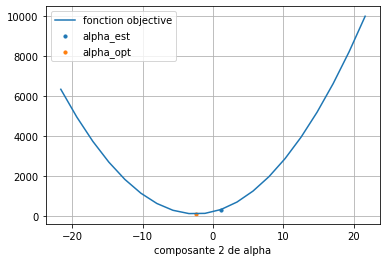

In [243]:
i = 2
lam = 3
alpha_test = golden_section_search(y,X,lam,alpha_est,i)
space_alphas = numpy.matlib.repmat(alpha_est,20,1).transpose()
space_alphas[i,:] = space_alphas[i,:]*np.linspace(-20,20,20)
OBJ_FCT =[]
for l in range(20):
    alph = space_alphas[:,l]
    OBJ_FCT .append(objective_fct_LS(y, X, alph,lam))           
plt.figure()
plt.plot(space_alphas[i,:],OBJ_FCT,label='fonction objective')
plt.scatter(alpha_est[i],objective_fct_LS(y, X, alpha_est,lam),s=10,label='alpha_est')
plt.scatter(alpha_test[i],objective_fct_LS(y, X, alpha_test,lam),s=10,label='alpha_opt')
plt.xlabel('composante 2 de alpha')
plt.legend()
plt.grid(True)
plt.show()

### loi d'Armijo

La fonction suivante trouve la solution du problème univarié avec la loi d'Armijo. Elle permet de déterminer la valeur du pas $\alpha$ qui minimisera au mieux, dans la composante $i$, la fonction objective. 

Si la subdifférentielle est négatif, la direction de descent est 1, si elle est positive, la direction de descent est -1. Quand la subdifférentielle vaut $0$, la valeur de alpha_est dans cette composante est déjà optimisée. 

Quand la subdifférentielle est un intervalle, on prend le minimum des deux bornes. Si l'intervalle de la subdifférentielle comprend $0$, la valeur de alpha_est dans cette composante est optimisée. (Les deux derniers arguments de la fonction qui calcule la subdifférentielle sont programmés pour renvoyer $0$ si les deux bornes de l'intervalle ont un signe contraire)

In [244]:
def armijo(y,X,lam,alpha_est,i, poisson = 0):
    alpha_test =alpha_est.copy()
    if False :
        x_i = X[:,i]
        X_wth_i = X.copy()
        X_wth_i[:,i] = 0
        alpha_wth_i = alpha_test.copy()
        alpha_wth_i[i] = 0     
        r = y-np.dot(X_wth_i,alpha_wth_i)
        prdt_scal = np.dot(x_i,r)
        alpha_test[i] = np.sign(prdt_scal)* np.max([0, (np.abs(prdt_scal-lam))/(np.linalg.norm(x_i)**2)])
        
    elif poisson ==0 :
        # calcul de la subdifferentielle
        _,_,sub_diff = subdifferential_LS(y,X,lam, alpha_test)
        
        # choix de la direction d en fonction du signe de la subdifferentielle 
        if sub_diff[i] > 0:
            d = -1
        elif sub_diff[i] < 0:
            d = 1
        elif  sub_diff[i] == 0:   
                return alpha_test
                    
        # initialisation
        m = 0
        beta = 0.5
        sigma = 0.1 
        borne = -sigma*d*sub_diff[i]
        j=0
        
        # tant que la décroissance ne passe pas un certain seuil déterminé par la subdifferentielle
        while objective_fct_LS(y, X, alpha_est,lam)-objective_fct_LS(y, X, alpha_test,lam) < (beta**m)*borne and j<15:
            m+=1
            alpha_test[i] =  alpha_est[i]+ (beta**m)*d
            #print('alpha', alpha_test)
            j+=1
            #print('test',objective_fct_LS(y, X, alpha_est,lam)-objective_fct_LS(y, X, alpha_test,lam),'borne', (beta**m)*borne)
    
    else :         
        # calcul de la subdifferentielle
        _,_,sub_diff = subdifferential_poisson(y,X,lam, alpha_test)
        print('sub',sub_diff)
        
        # choix de la direction d en fonction du signe de la subdifferentielle 
        if sub_diff[i] > 0:
            d = -1
        elif sub_diff[i] < 0:
            d = 1
        elif  sub_diff[i] == 0:   
                return alpha_test
        
        # initialisation
        m = 0
        beta = 0.5
        sigma = 0.001
        borne = -sigma*d*sub_diff[i]
        
        # tant que la décroissance ne passe pas un certain seuil déterminé par la subdifferentielle
        while objective_fct_poisson(y, X, alpha_est,lam)-objective_fct_poisson(y, X, alpha_test,lam) < (beta**m)*borne :
            #print('diff obj',objective_fct_poisson(y, X, alpha_est,lam)-objective_fct_poisson(y, X, alpha_test,lam),'borne',(beta**m)*borne)
            m+=1
            alpha_test[i] =  alpha_est[i]+ (beta**m)*d
            #print(alpha_test[i],m)
    return alpha_test

#### Test
Testons cette fonction pour $i = 2$, et $\lambda =3$. De la même manière que pour Golden section, en alpha_opt la fonction objective atteint un minimum local pour la composante 2.

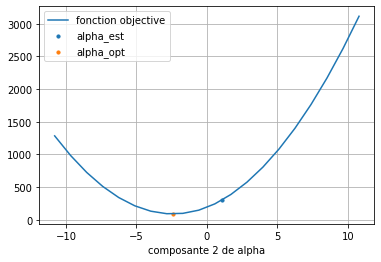

In [246]:
i = 2
lam =3
armijo(y,X,lam,alpha_est,i, poisson = 0)

space_alphas = numpy.matlib.repmat(alpha_est,20,1).transpose()
space_alphas[i,:] = space_alphas[i,:]*np.linspace(-10,10,20)
OBJ_FCT =[]
for l in range(20):
    alph = space_alphas[:,l]
    OBJ_FCT .append(objective_fct_LS(y, X, alph,lam))           
plt.figure()
plt.plot(space_alphas[i,:],OBJ_FCT,label='fonction objective')
plt.scatter(alpha_est[i],objective_fct_LS(y, X, alpha_est,lam),s=10,label='alpha_est')
plt.scatter(alpha_test[i],objective_fct_LS(y, X, alpha_test,lam),s=10,label='alpha_opt')
plt.xlabel('composante 2 de alpha')
plt.legend()
plt.grid(True)
plt.show()


##  4 Implémentation de LASSO
### Input 
La fonction LASSO prend en input :
- $y$ 
- $X$
- "alpha_initial"
- $\lambda$
- "optimal_descent", un booléen qui permet de sélectionner la méthode du choix des prochains indices. Par défaut, optimal_descent $=1$     
-  "poisson", un booléen qui permet de sélectionner si les données proviennent de la réalisation d'une loi de Poisson. Par défaut, poisson $= 0$
- "selec_stop" peut prendre les valeurs : 'diff_norm_inf','diff_norm_2', 'subdiff_norm_inf','subdiff_norm_2'. Cette variable permet de choisir la méthode utilisée pour déterminer le critère d'arrêt
- "golden_section", un booléen qui permet de sélectionner la méthode d'optimisation univariée
- "iter_max", le nombre d'itération maximal. Par défaut : iter_max $=500$
- "eps", la précision de la convergence. Par défaut : eps $= 10^{-3}$

### Output 
- "alpha_est"
- "nb_iter", nombre d'itération pour atteindre le critère d'arrêt
- "indice", vecteur contenant les indices des composantes optimisées pour chaque itération
- "OBJ_FCT", vecteur contenant la valeur de la fonction objective à chaque itération
- "ALPHAS", matrice contenant la valeur de alpha_est à chaque itération
- "CPU_time", vecteur contenant le temps de calcul de l'optimisation univariée pour chaque itération 
- "CONDITION_ARRET",vecteur contenant la  valeur du critère d'arrêt pour chaque itération ( cf la section: " critère d'arrêt") 

### Vérifications
Pour être sûr que tout fonctionnne correctement, on vérifie l'existence de la solution avec la fonction "existence_test(X)", précédement implémentée. On teste aussi si les tailles des variables en input de la fonction sont compatibles. Pour finir à chaque itération de la fonction LASSO, on test si la fonction objective décroit.  

### Choix du prochain indice 
Pour choisir le prochain indice de l'algorithme de relaxation, nous avons implémenté deux méthodes.

- méthode naive : on incrémente de 1 l'indice à chaque itération et quand l'indice est égale à la dimension de $\alpha$, le prochain indice est 1.
- méthode optimale : on calcule la subdifférentielle en alpha_est et on choisit l'indice où sa valeur absolue est maximale. 

### Critère d'arrêt
Signification des différents critères d'arrêt de la fonction :
- 'diff_norm_inf', "LASSO" s'arrête quand la norme infinie de la différence entre alpha_est et alpha_next est plus petite que eps
- 'diff_norm_2', "LASSO" s'arrête quand la norme 2 de la différence entre alpha_est et alpha_next est plus petite que eps
- 'subdiff_norm_inf', "LASSO" s'arrête quand la norme infinie de la subdifférencielle de alpha_est est plus petite que eps
- 'subdiff_norm_2', "LASSO" s'arrête quand la norme 2 de la subdifférencielle de alpha_est est plus petite que eps

In [247]:
def LASSO(y,X,alpha_initial,lam, optimal_descent = 1,  poisson =0, selec_stop = 'diff_norm_inf', golden_section =0, iter_max =500, eps = 10**-3):
   #test existence
    if existence_test(X):
        print('La matrice X est de rang maximal, la solution existe')
    else:  
        print("La matrice X n'est pas de rang maximal, la solution n'existe pas")
    
   # test taille
    if y.shape[0] != X.shape[0] :
        print ("probleme de dimension entre y et X")
    if alpha_initial.shape[0] != X.shape[1]:
        print ("probleme de dimension entre alpha et X")
    
   #initialisation

    [n,p] = X.shape
    alpha_est =alpha_initial.copy()
    
    i = 0
    nb_iter = 0
    stop = 0 
    indice = []

    ALPHAS =np.empty((p,iter_max+1))
    ALPHAS[:] =np.NaN
    ALPHAS[:,nb_iter] = alpha_initial.copy()
    OBJ_FCT = np.zeros((iter_max+1))
    CPU_time = []
    CONDITION_ARRET = []
    
    # calcul de la fonction objective pour alpha initial
    OBJ_FCT[nb_iter] = objective_fct_LS(y, X, alpha_est,lam)
    
    
    while stop == 0 and nb_iter<iter_max :
        nb_iter +=1 
        time_start = timeit.timeit()
        
       # choix du prochain indice    
        if optimal_descent :
            if poisson == 0 :
                #print('sub',subdifferential_LS(y,X,lam, alpha_est)[0])
                max_sub =  np.argmax(subdifferential_LS(y,X,lam, alpha_est)[1])
                if max_sub ==i :
                    i = (i + 1) % p
                else:    
                    i = max_sub  
            else :
                max_sub =  np.argmax(subdifferential_poisson(y,X,lam, alpha_est)[1])
                if max_sub ==i :
                    i = (i + 1) % p
                else :   
                    i = max_sub  
        else : # cycling
            i = (i + 1) % p
        indice.append(i)
        
        if golden_section :
            if poisson == 0 : 
                alpha_next = golden_section_search(y,X,lam,alpha_est,i, poisson = 0,eps=1e-5)
            else : 
                alpha_next = golden_section_search(y,X,lam,alpha_est,i, poisson = 1,eps=1e-5)
            
        else: #armijo             
            if poisson == 0 : 
                alpha_next = armijo(y,X,lam,alpha_est,i)
            else:  
                alpha_next = armijo(y,X,lam,alpha_est,i, poisson = 1)
            #print(f' alpha_next{alpha_next}')
           
        # calcul CPU time
        time_end = timeit.timeit()   
        CPU_time.append(np.abs(time_end-time_start))        
        
        #vérification que la fonction objective décroit
        if poisson ==0 :
           OBJ_FCT[nb_iter] = objective_fct_LS(y, X, alpha_next,lam)
        else:
            OBJ_FCT[nb_iter] = objective_fct_poisson(y, X, alpha_next,lam)
            
        if  OBJ_FCT[nb_iter-1] > OBJ_FCT[nb_iter] or OBJ_FCT[nb_iter-1] == OBJ_FCT[nb_iter]:
           print(f'iter{nb_iter}, opti sur compo {i}, fct obj = {OBJ_FCT[nb_iter]}')
        else:
            print('Probleme : la fonction objective croit ')
            
       # stop 
        if selec_stop == 'diff_norm_inf':
            #condition_arret = np.linalg.norm(objective_fct_LS(y, X, alpha_next,lam)- objective_fct_LS(y, X, alpha_est,lam),ord = math.inf)
            condition_arret = np.linalg.norm(alpha_next-alpha_est,ord = math.inf)
            print('condition arret', condition_arret)     
            CONDITION_ARRET.append(condition_arret)
            if condition_arret < eps :
                    stop = 1
                    
        elif selec_stop == 'diff_norm_2':
            condition_arret = np.linalg.norm(alpha_next-alpha_est,ord = 2)
            print('condition arret', condition_arret)
            CONDITION_ARRET.append(condition_arret)
            if condition_arret < eps :
                    stop = 1
                    
        elif selec_stop == 'subdiff_norm_inf':
            if poisson == 0:
                condition_arret = np.linalg.norm(subdifferential_LS(y,X,lam, alpha_est)[1], ord = math.inf)
                CONDITION_ARRET.append(condition_arret)
                print('condition arret', condition_arret) 
                if condition_arret < eps :
                    stop = 1
                   
            else :
                condition_arret = np.linalg.norm(subdifferential_poisson(y,X,lam, alpha_est)[1], ord = math.inf)
                CONDITION_ARRET.append(condition_arret)
                print('condition arret', condition_arret)
                if condition_arret < eps :
                    stop = 1
                    
        elif selec_stop == 'subdiff_norm_2':    
            if poisson == 0:   
                condition_arret= np.linalg.norm(subdifferential_LS(y,X,lam, alpha_est)[1]) 
                CONDITION_ARRET.append(condition_arret)
                print('condition arret', condition_arret)
                if condition_arret < eps :
                    stop = 1
                    
            else :
                condition_arret = np.linalg.norm(subdifferential_poisson(y,X,lam, alpha_est)[1])
                CONDITION_ARRET.append(condition_arret)
                print('condition arret', condition_arret) 
                if condition_arret < eps :
                    stop = 1
                    
        #stock la valeur de alpha
        alpha_est = alpha_next.copy()          
        ALPHAS[:,nb_iter] = alpha_next.copy()
        
    if nb_iter != iter_max:
        print(' LASSO a convergé')
    else : 
        print(' LASSO n a pas convergé')
    
    return alpha_est, nb_iter, indice, OBJ_FCT, ALPHAS, CPU_time,CONDITION_ARRET

### Test de LASSO 1 :
- choix des prochains indices via la méthode naive
- critère d'arrêt : 'subdiff_norm_2'
- algorithme de minimisation univarié : Armijo rule

In [248]:
alpha_initial = 2*np.ones(X.shape[1]) 
alpha_est, nb_iter, indice, OBJ_FCT, ALPHAS, CPU_time, CONDITION_ARRET = LASSO(y,X,alpha_initial,lam, optimal_descent = 0,  poisson =0, selec_stop = 'subdiff_norm_2', iter_max =500, eps = 10**-3,golden_section =0)

La matrice X est de rang maximal, la solution existe
iter1, opti sur compo 1, fct obj = 1026.6022072707647
condition arret 605.0029419577749
iter2, opti sur compo 2, fct obj = 911.7392943417096
condition arret 570.4305963574118
iter3, opti sur compo 3, fct obj = 804.2841515999711
condition arret 537.5595071599637
iter4, opti sur compo 4, fct obj = 696.3451594369517
condition arret 504.60575723154136
iter5, opti sur compo 5, fct obj = 608.3081975632387
condition arret 469.33519104044797
iter6, opti sur compo 0, fct obj = 530.7813133172742
condition arret 437.8331828269038
iter7, opti sur compo 1, fct obj = 449.32945796594214
condition arret 408.67780279916656
iter8, opti sur compo 2, fct obj = 374.65918209482516
condition arret 374.1332695348964
iter9, opti sur compo 3, fct obj = 307.4491878972321
condition arret 341.25375113759196
iter10, opti sur compo 4, fct obj = 242.42430627676404
condition arret 308.30165405507927
iter11, opti sur compo 5, fct obj = 192.97484263540338
condition ar

#### Analyse des résultats

In [249]:
print('Nombres d itération :', nb_iter)
print('alpha estimé :', alpha_est)
erreur = mean_square_error(y, X, alpha_est)
print('Erreur du alpha estimé', erreur)

Nombres d itération : 432
alpha estimé : [0.61959839 0.80413818 0.06924438 0.20785522 0.2114563  0.87945557]
Erreur du alpha estimé 0.00599406386923137


#### Affichage des résultats
On affiche la fonction objective et la norme de la subdifferentielle en fonction du nombre d'itérations, ainsi que la fonction objective en fonction du CPU time.

Remarque : échelle logarithmique pour l'axe des ordonnées

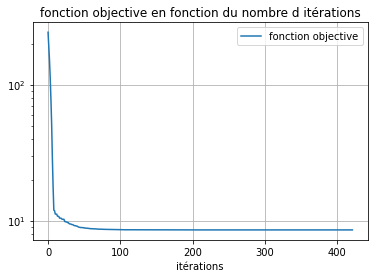

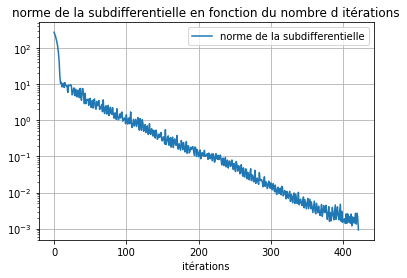

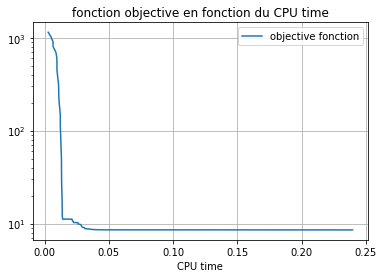

In [250]:
plt.figure()
plt.plot(OBJ_FCT[10:nb_iter],label='fonction objective')
plt.xlabel('itérations')
plt.title('fonction objective en fonction du nombre d itérations')
plt.yscale('log') # echelle logarithmique pour l'axe des ordonnées
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(CONDITION_ARRET[10:nb_iter],label='norme de la subdifferentielle')
plt.title('norme de la subdifferentielle en fonction du nombre d itérations')
plt.xlabel('itérations')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot([sum(CPU_time[0:i+1]) for i in range(len(CPU_time))],OBJ_FCT[0:nb_iter],label='objective fonction')
plt.xlabel('CPU time')
plt.title('fonction objective en fonction du CPU time')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

### Test de LASSO 2 :
- choix des prochains indices via la méthode optimale
- critère d'arrêt : 'subdiff_norm_inf'
- algorithme de minimisation univarié : Golden section

In [251]:
alpha_initial = 2*np.ones(X.shape[1]) 
alpha_est, nb_iter, indice, OBJ_FCT, ALPHAS, CPU_time, CONDITION_ARRET = LASSO(y,X,alpha_initial,lam, optimal_descent = 1,  poisson =0, selec_stop = 'subdiff_norm_inf', iter_max =500, eps = 10**-3,golden_section =1)

La matrice X est de rang maximal, la solution existe
iter1, opti sur compo 4, fct obj = 263.0961574208136
condition arret 266.75110256926666
iter2, opti sur compo 2, fct obj = 190.46634348497577
condition arret 70.20493675458827
iter3, opti sur compo 4, fct obj = 153.02106868182386
condition arret 53.935174349299565
iter4, opti sur compo 1, fct obj = 110.86392356918383
condition arret 56.05789845237492
iter5, opti sur compo 4, fct obj = 88.21457819044223
condition arret 41.94704800573894
iter6, opti sur compo 3, fct obj = 64.39848389449347
condition arret 39.907804846943854
iter7, opti sur compo 4, fct obj = 50.56329912290384
condition arret 32.78431075896448
iter8, opti sur compo 0, fct obj = 34.58219536822594
condition arret 30.47167585679541
iter9, opti sur compo 4, fct obj = 26.886497722772056
condition arret 24.45105340046204
iter10, opti sur compo 5, fct obj = 20.221553214419437
condition arret 20.36173784573408
iter11, opti sur compo 4, fct obj = 16.14690318834976
condition arre

#### Analyse des résultats 

In [252]:
print('Nombres d itération :', nb_iter)
print('alpha estimé :', alpha_est)
erreur = mean_square_error(y, X, alpha_est)
print('Erreur du alpha estimé', erreur)

Nombres d itération : 129
alpha estimé : [0.6197015  0.80400597 0.06909864 0.20796215 0.21143938 0.87955609]
Erreur du alpha estimé 0.005993280082594333


#### Affichage des résulats

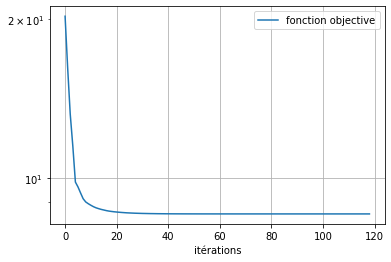

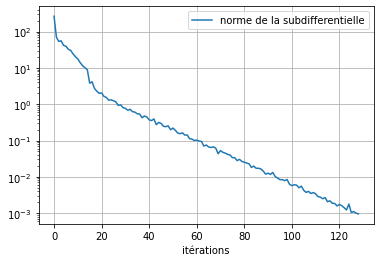

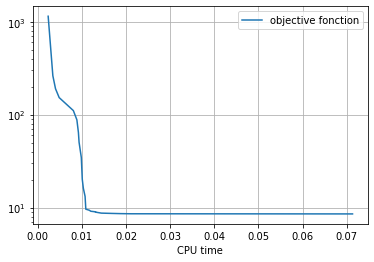

In [253]:
plt.figure()
plt.plot(OBJ_FCT[10:nb_iter],label='fonction objective')
plt.xlabel('itérations')
plt.legend()
plt.yscale('log')
plt.grid(True)

plt.figure()
plt.plot(CONDITION_ARRET[0:nb_iter],label='norme de la subdifferentielle')
plt.xlabel('itérations')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot([sum(CPU_time[0:i+1]) for i in range(len(CPU_time))],OBJ_FCT[0:nb_iter],label='objective fonction')
plt.xlabel('CPU time')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

### Test de LASSO 3 : comparaison de la rapidité de convergence selon la méthode de choix des prochains indices
On lance la fonction "LASSO" deux fois avec les mêmes paramètres, excepté le paramètre de choix de la méthode utilisée pour déterminer les prochains indices.

On choisit par ailleurs :
- critère d'arrêt : 'subdiff_inf'
- algorithme de minimisation univarié : Golden section
- nombre d'itération maximal : 500

In [254]:
alpha_est1, nb_iter1, indice, OBJ_FCT1, ALPHAS, CPU_time1, CONDITION_ARRET1 = LASSO(y,X,alpha_initial,lam, optimal_descent = 0,  poisson =0, selec_stop = 'subdiff_norm_inf', iter_max =500, eps = 10**-3,golden_section =1)
alpha_est2, nb_iter2, indice, OBJ_FCT2, ALPHAS, CPU_time2, CONDITION_ARRET2 = LASSO(y,X,alpha_initial,lam, optimal_descent = 1,  poisson =0, selec_stop = 'subdiff_norm_inf', iter_max =500, eps = 10**-3,golden_section =1)


La matrice X est de rang maximal, la solution existe
iter1, opti sur compo 1, fct obj = 295.1592984301257
condition arret 266.75110256926666
iter2, opti sur compo 2, fct obj = 211.15512119055686
condition arret 79.15768842908331
iter3, opti sur compo 3, fct obj = 209.29694902770868
condition arret 53.746144352173744
iter4, opti sur compo 4, fct obj = 206.62395334540358
condition arret 62.92277513886341
iter5, opti sur compo 5, fct obj = 205.80715947610798
condition arret 73.26950968914562
iter6, opti sur compo 0, fct obj = 205.54700476078477
condition arret 67.34994733895596
iter7, opti sur compo 1, fct obj = 150.44401789483172
condition arret 64.0897808286368
iter8, opti sur compo 2, fct obj = 132.55001501090615
condition arret 57.305385962447765
iter9, opti sur compo 3, fct obj = 127.21253527500195
condition arret 29.59323261797768
iter10, opti sur compo 4, fct obj = 124.66314412215547
condition arret 42.345233525302596
iter11, opti sur compo 5, fct obj = 124.63478031806008
condition

#### Analyse  des résultats 

In [256]:
print('Nombres d itération methode naive ', nb_iter1, 'optimisée',nb_iter2)
print('alpha', alpha)
print('alpha estimé methode naive ', alpha_est1)
print('alpha estimé optimisée', alpha_est2 )
erreur1 = mean_square_error(y, X, alpha_est1)
erreur2 = mean_square_error(y, X, alpha_est2)
print('Erreur du alpha estimé methode naive', erreur1, 'optimisée', erreur2 )

Nombres d itération methode naive  314 optimisée 129
alpha [0.67456402 0.79977654 0.08052953 0.23170231 0.20762566 0.91733356]
alpha estimé methode naive  [0.61974293 0.8040939  0.06910528 0.20780657 0.21147924 0.87954124]
alpha estimé optimisée [0.6197015  0.80400597 0.06909864 0.20796215 0.21143938 0.87955609]
Erreur du alpha estimé methode naive 0.005993007847731607 optimisée 0.005993280082594333


#### Affichage des résultats
On voit clairement que la méthode de descente optimisée converge plus rapidement que la méthode naive.

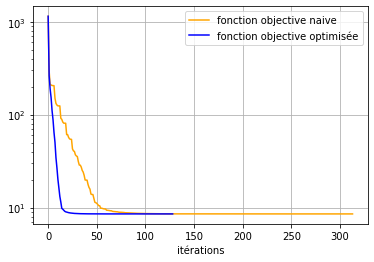

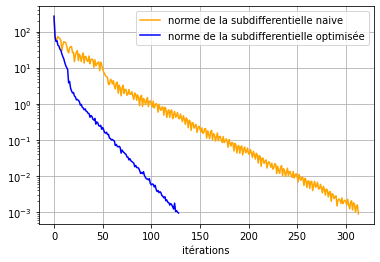

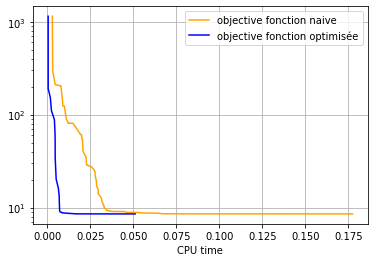

In [257]:
plt.figure()
plt.plot(OBJ_FCT1[0:nb_iter1],color='orange',label='fonction objective naive')
plt.plot(OBJ_FCT2[0:nb_iter2],color='blue',label='fonction objective optimisée')
plt.xlabel('itérations')
plt.yscale('log')
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(CONDITION_ARRET1[0:nb_iter1],color='orange',label='norme de la subdifferentielle naive')
plt.plot(CONDITION_ARRET2[0:nb_iter2],color='blue',label='norme de la subdifferentielle optimisée')
plt.xlabel('itérations')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot([sum(CPU_time1[0:i+1]) for i in range(len(CPU_time1))],OBJ_FCT1[0:nb_iter1],color='orange',label='objective fonction naive')
plt.plot([sum(CPU_time2[0:i+1]) for i in range(len(CPU_time2))],OBJ_FCT2[0:nb_iter2],color='blue',label='objective fonction optimisée')
plt.xlabel('CPU time')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

## 6  LASSO path
La fonction " warm_start" permet de calculer le LASSO path en utilisant le principe de warm start.
La fonction "plot_LASSO_path" permet d'afficher le LASSO path.

### Input 
Les input de la fonction sont :
- $y$ 
- $X$
- "optimal_descent"    
-  "poisson"
- "selec_stop" 
- "golden_section"
- "iter_max", 
- "eps"
- "nb_lam", le nombre de fois que l'on appelle la fonction LASSO

### Output
Les output de la fonction sont :
- LASSO_PATH, matrice contenant les $\alpha$ solutions de LASSO pour les différents $\lambda$
- LAM, vecteur contenant la grille des $\lambda$ 
- NB_ITER, vecteur contenant le nombre d'itération pour chaque $\lambda$
- lam_0, le premier $\lambda$  dont la solution du problème d'optimisation est le vecteur nul 

### lam_0
La formule permettant de trouver $\lambda_0$ est différente selon la nature des données.


Si les données proviennent d'un bruit gaussien : $ \lambda_0 = \| X^T y\|_\infty$ 
Par contre si elles proviennent d'une loi de Poisson :  $ \lambda_0 = \| X^T(1-y)\|_\infty $. 

On peut vérifier le bon fonctionnement de la fonction "LASSO", en testant si lam = lam_0 donne bien la solution alpha_est égale au vecteur nul.


In [258]:
def warm_start(y,X, optimal_descent = 0, selec_stop = 'subdiff_norm_2', iter_max =500, eps = 10**-3,nb_lam = 20,poisson =0, golden_section =1):
    [n,p] = X.shape
    if poisson ==0 :
        lam_0 = np.linalg.norm(np.dot(np.transpose(X),y), ord = math.inf)
    else:

        lam_0 = np.linalg.norm(np.abs(np.dot(np.transpose(X),np.ones(n)-y)), ord = math.inf)
        
    # test si lam_0 donne bien la solution alpha_est = 0
    alpha_initial = np.zeros(p)
    [alpha_est, nb_iter, indice,OBJ_FCT, ALPHAS, CPU_time,CONDITION_ARRET] = LASSO(y,X,alpha_initial,lam_0, optimal_descent = 0,selec_stop = 'full_diff', iter_max =100, eps = 10**-6)
    if all(alpha_est) ==0 :
        print( "La solution de lambda_0 est bien alpha = 0")
    else:
         print(f"probleme : La solution de LASSO avec lambda_0 est {alpha_est}")
            
    #initialisation
    LAM = np.linspace(0, lam_0+1,nb_lam)
    alpha_0 = np.zeros(p)
    LASSO_PATH = np.zeros((p,nb_lam))
    LASSO_PATH[:,-1] = alpha_0 
    NB_ITER = np.zeros(nb_lam)
    j = nb_lam 
    
    while j != 1:
        [alpha_est, nb_iter, indice,OBJ_FCT, ALPHAS,_,CONDITION_ARRET] = LASSO(y,X,LASSO_PATH[:,j-1],LAM[j-2], optimal_descent,poisson,selec_stop, golden_section, iter_max, eps)
        j = j-1
        LASSO_PATH[:,j] = alpha_est
        NB_ITER[j] = nb_iter
    LASSO_PATH[:,0] = np.linalg.lstsq(X, y)[0]
    return LASSO_PATH,LAM, NB_ITER,lam_0

def plot_LASSO_path(LASSO_PATH,LAM):  
    plt.figure()
    plt.plot(LAM,np.transpose(LASSO_PATH))
    #plt.xscale('log')
    plt.title('LASSO path')
    plt.xlabel('lambda')
    plt.ylabel('alpha')
    plt.grid(True)
    plt.legend()    
    plt.show() 

### Test warm start
On teste la fonction avec les paramètres suivants :
- choix des prochains indices via la méthode optimale
- critère d'arrêt : 'subdiff_norm_2'
- algorithme de minimisation univarié : golden section


In [259]:
[LASSO_PATH, LAM, NB_ITER,lam_0] = warm_start(y,X, optimal_descent = 1, selec_stop = 'subdiff_norm_2', iter_max =200, eps = 10**-3,nb_lam = 20,poisson =0, golden_section= 1)   
print('lam_0', lam_0)

La matrice X est de rang maximal, la solution existe
Probleme : la fonction objective croit 
iter2, opti sur compo 2, fct obj = 112.64083955118956
iter3, opti sur compo 3, fct obj = 112.64083955118956
iter4, opti sur compo 4, fct obj = 112.64083955118956
iter5, opti sur compo 5, fct obj = 112.64083955118956
iter6, opti sur compo 0, fct obj = 112.64083955118956
iter7, opti sur compo 1, fct obj = 112.64083953383384
iter8, opti sur compo 2, fct obj = 112.64083953383384
iter9, opti sur compo 3, fct obj = 112.64083953383384
iter10, opti sur compo 4, fct obj = 112.64083953383384
iter11, opti sur compo 5, fct obj = 112.64083953383384
iter12, opti sur compo 0, fct obj = 112.64083953383384
Probleme : la fonction objective croit 
iter14, opti sur compo 2, fct obj = 112.64083955118956
iter15, opti sur compo 3, fct obj = 112.64083955118956
iter16, opti sur compo 4, fct obj = 112.64083955118956
iter17, opti sur compo 5, fct obj = 112.64083955118956
iter18, opti sur compo 0, fct obj = 112.6408395511

/Users/lucilealysfavero/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


#### Affichage du LASSO path 

No handles with labels found to put in legend.


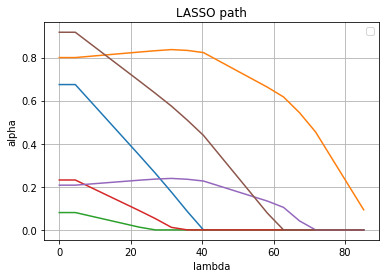

In [260]:
plot_LASSO_path(LASSO_PATH,LAM)

# II LASSO Poisson

## 1 Fonction objective et subdifferentielle
On suppose que $y_i$  ~ Poisson$(\sum_{j=1}^p \alpha_j x_{ij})$ pour $i=1,...,n$

On a alors la MLE : $ \sum_{i=1}^n \big( \exp (\alpha^T x_i)- y_i \alpha^T x_i\big)$ avec $\alpha$ de dimension $p$ 

La fonction objective dans le cadre de LASSO est donc :
$$ f(\alpha) = 0.5 \|  \sum_{i=1}^n \big(exp(\alpha^T x_i)- y_i \alpha^T x_i\big) \|_2^2  + \lambda \|\alpha \|_1$$

La subdifférentielle est : 
$$\partial f(\alpha) = \{X^T(\exp(X \alpha) - y)\} + \lambda s$$ 
où $s_j = \{sign(\alpha_j)\}$ si $ \alpha_j\ne 0$ et $s_j = [-1,1]$ si $ \alpha_j = 0$, $j = 1, ...,p$

## 2 Génère les données

In [261]:
n = 100
p = 6 
[y,X,alpha] = crea_data(n,p, poisson = 1)
print(alpha)

[0.67456402 0.79977654 0.08052953 0.23170231 0.20762566 0.91733356]


## 3 Test LASSO poisson
On choisit : 
- $\lambda = 10$
- choix des prochains indices via la méthode naive
- critère d'arrêt : 'subdiff_norm_2'
- algorithme de minimisation univarié : armijo rule
- nombre d'itération maximum : 20

In [262]:
lam = 10
alpha_initial = alpha +0.5*np.ones(X.shape[1]) 
alpha_est, nb_iter, indice, OBJ_FCT, ALPHAS, CPU_time, CONDITION_ARRET = LASSO(y,X,alpha_initial,lam, optimal_descent = 0,  poisson =1, selec_stop = 'subdiff_norm_2', iter_max =20, eps = 10**-3,golden_section =0)


La matrice X est de rang maximal, la solution existe
sub [1013.43944837 1251.27598262 1094.335679   1125.73506105 1231.96031031
 1176.45830072]
Probleme : la fonction objective croit 
condition arret 2821.2375734291695
sub [690.42065786 781.92640077 760.45737865 766.67745297 846.42183292
 805.69987698]
iter2, opti sur compo 2, fct obj = 10150.855288684319
condition arret 1902.5670904556916
sub [480.05234855 547.40926704 470.28545337 530.33397617 597.41424163
 566.31687806]
iter3, opti sur compo 3, fct obj = 1695.1892448999106
condition arret 1307.7263778733993
sub [321.82531631 353.9584166  303.08671536 310.67710968 398.80027608
 375.61174193]
iter4, opti sur compo 4, fct obj = 1695.1892448999106
condition arret 846.9744738075713
sub [321.82531631 353.9584166  303.08671536 310.67710968 398.80027608
 375.61174193]
iter5, opti sur compo 5, fct obj = 1695.1892448999106
condition arret 846.9744738075713
sub [321.82531631 353.9584166  303.08671536 310.67710968 398.80027608
 375.61174193]
it

### Analyse des résulats

In [263]:
print('Nombres d itération :', nb_iter)
print('alpha',alpha)
print('alpha estimé :', alpha_est)

erreur = mean_square_error(y, X, alpha_est)
print('Erreur du alpha estimé', erreur)

Nombres d itération : 20
alpha [0.67456402 0.79977654 0.08052953 0.23170231 0.20762566 0.91733356]
alpha estimé : [1.17456402 0.79977654 0.08052953 0.23170231 0.70762566 1.41733356]
Erreur du alpha estimé 0.35625262500212296


### Affichage des résultats

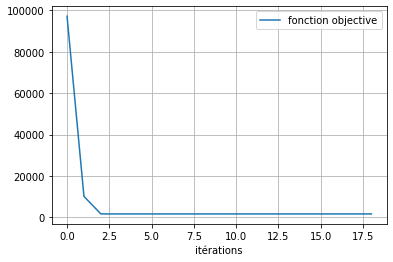

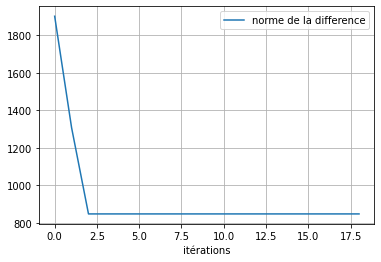

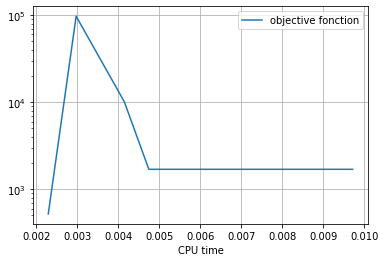

In [264]:
plt.figure()
plt.plot(OBJ_FCT[1:nb_iter],label='fonction objective')
plt.xlabel('itérations')
#plt.yscale('log')
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(CONDITION_ARRET[1:nb_iter],label='norme de la difference')
plt.xlabel('itérations')
#plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot([sum(CPU_time[0:i+1]) for i in range(len(CPU_time))],OBJ_FCT[0:nb_iter],label='objective fonction')
plt.xlabel('CPU time')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()


# III Application : LASSO path de la prostate


Nous allons maintenant reconstruire le LASSO path pour les données de la prostate.
Commençons par extraire et traiter les données.

## 1 Extraction des données

In [265]:
#extraction des données
data_prost_path = "/Users/lucilealysfavero/Library/Mobile Documents/com~apple~CloudDocs/STUDY/MATH/OPTI/opt_final_projet/prosta.txt"
data_set = pd.read_csv(data_prost_path, sep = " ")
data_set.head()
print(data_set.columns)

# traitement des données
columns_sorted = sorted(data_set.columns, key="y".__eq__)
data_set = data_set.reindex(columns_sorted, axis=1)
data_set.head()
data = np.array(data_set)
X = data[:,0:-1] 
y = data[:,-1]


Index(['y', 'lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason',
       'pgg45'],
      dtype='object')


## 2 Test 
Calculons tout d'abord le LASSO pour un $\lambda$ donné. On choisit : 
- $\lambda = 50$
- choix des prochains indices via la méthode optimale
- critère d'arrêt : 'diff_norm_2'
- algorithme de minimisation univarié : golden section
- nombre d'itération maximum : 100

In [267]:
lam = 50
alpha_initial = 0.5*np.ones(X.shape[1]) 
alpha_est, nb_iter, indice, OBJ_FCT, ALPHAS, CPU_time, CONDITION_ARRET = LASSO(y,X,alpha_initial,lam, optimal_descent = 1,  poisson =0, selec_stop = 'diff_norm_2', iter_max =100, eps = 10**-3,golden_section =1)

La matrice X est de rang maximal, la solution existe
iter1, opti sur compo 2, fct obj = 10074.59677728917
condition arret 0.7495991926805161
iter2, opti sur compo 7, fct obj = 4709.390818156901
condition arret 0.28294443833406696
iter3, opti sur compo 2, fct obj = 2260.739377610934
condition arret 0.11051989570842102
iter4, opti sur compo 7, fct obj = 1143.001990399867
condition arret 0.12915570585463393
iter5, opti sur compo 2, fct obj = 632.9238222538643
condition arret 0.050430082078964475
iter6, opti sur compo 7, fct obj = 400.28535977721936
condition arret 0.0589175726760023
iter7, opti sur compo 2, fct obj = 294.0271749631813
condition arret 0.023020272284456633
iter8, opti sur compo 7, fct obj = 245.5322077257638
condition arret 0.026891510051739745
iter9, opti sur compo 2, fct obj = 223.40896712944664
condition arret 0.010514183332465503
iter10, opti sur compo 7, fct obj = 214.26167889748635
condition arret 0.01155899494209938
iter11, opti sur compo 2, fct obj = 210.19255560303

### Analyse des résultats 

In [268]:
print('Nombres d itération :', nb_iter)
print('alpha estimé :', alpha_est)

erreur = mean_square_error(y, X, alpha_est)
print('Erreur du alpha estimé', erreur)

Nombres d itération : 15
alpha estimé : [ 0.5         0.5        -0.04760915  0.5         0.5         0.5
  0.5        -0.01712784]
Erreur du alpha estimé 0.10683823512009848


### Affichage des résultats 
on a bien convergence vers un minimum

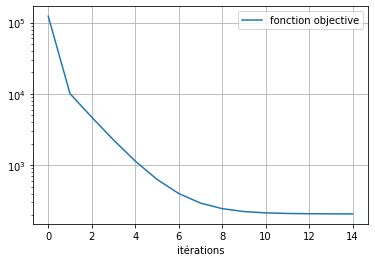

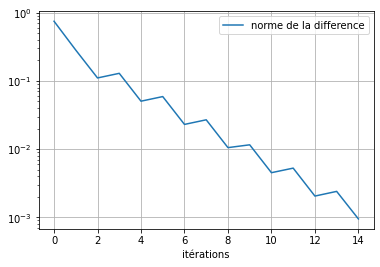

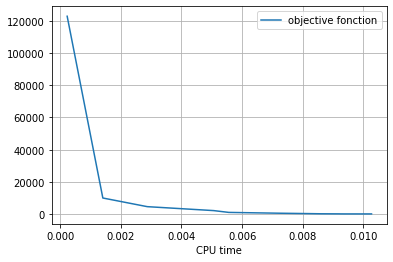

In [269]:
plt.figure()
plt.plot(OBJ_FCT[0:nb_iter],label='fonction objective')
plt.xlabel('itérations')
plt.yscale('log')
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(CONDITION_ARRET[0:nb_iter],label='norme de la difference')
plt.xlabel('itérations')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot([sum(CPU_time[0:i+1]) for i in range(len(CPU_time))],OBJ_FCT[0:nb_iter],label='objective fonction')
plt.xlabel('CPU time')
plt.grid(True)
plt.legend()
plt.show()

## 3 LASSO path 

Nous allons maintenant appliquer l'algorithme "warm_start" aux données dans le but d'obtenir le LASSO path.
On choisit : 
- choix des prochains indices via la méthode optimale
- critère d'arrêt : 'subdiff_norm_2'
- algorithme de minimisation univarié : golden section
- nombre d'itération maximum : 500
- nombre de lambda testé : 15

In [270]:
[LASSO_PATH, LAM, NB_ITER,lam_0] = warm_start(y,X, optimal_descent = 1, selec_stop = 'subdiff_norm_2', iter_max =500, eps = 10**-3,nb_lam = 15,poisson =0, golden_section =1)
   

La matrice X est de rang maximal, la solution existe
iter1, opti sur compo 1, fct obj = 361.8653033785543
Probleme : la fonction objective croit 
iter3, opti sur compo 3, fct obj = 361.86549009522633
iter4, opti sur compo 4, fct obj = 361.86549009522633
iter5, opti sur compo 5, fct obj = 361.86549009522633
iter6, opti sur compo 6, fct obj = 361.86549009522633
iter7, opti sur compo 7, fct obj = 361.86549009522633
iter8, opti sur compo 0, fct obj = 361.86549009522633
iter9, opti sur compo 1, fct obj = 361.86549009522633
iter10, opti sur compo 2, fct obj = 361.8653033785543
iter11, opti sur compo 3, fct obj = 361.8653033785543
iter12, opti sur compo 4, fct obj = 361.8653033785543
iter13, opti sur compo 5, fct obj = 361.8653033785543
iter14, opti sur compo 6, fct obj = 361.8653033785543
iter15, opti sur compo 7, fct obj = 361.8653033785543
iter16, opti sur compo 0, fct obj = 361.8653033785543
iter17, opti sur compo 1, fct obj = 361.8653033785543
Probleme : la fonction objective croit 
iter

/Users/lucilealysfavero/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


### Affichage du LASSO path
Remarque : On a un $\lambda_0$ très grand et seulement quelques paramètres qui ne sont pas nuls après avoir passé un certain seuil. Il n'est pas aisé de discriminer les différents paramètres dans l'intervalle $[0,2000]$

No handles with labels found to put in legend.


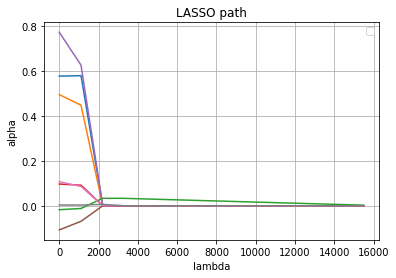

In [271]:
plot_LASSO_path(LASSO_PATH,LAM)

## 4 LASSO path adapté
Pour résoudre ce problème, on va modifier la fonction " warm_start" : on restreint la grille des $\lambda$ à l'intervalle $[0,80]$. 

Remarque : 
- On utilise toujours le principe du "warm start", seuls les lambdas employés dans "LASSO" sont différents. 
- On choisit cet intervalle ci car après plusieurs tests, il s'est avéré être le choix le plus pertinent. 

In [205]:
def warm_start_changed(y,X, optimal_descent = 1, selec_stop = 'subdiff_norm_2', iter_max =500, eps = 10**-3,nb_lam = 15,poisson =0, golden_section =1):
    [n,p] = X.shape
    if poisson ==0 :
        lam_0 = np.linalg.norm(np.dot(np.transpose(X),y), ord = math.inf)
    else:

        lam_0 = np.linalg.norm(np.abs(np.dot(np.transpose(X),np.ones(n)-y)), ord = math.inf)
        
    # test si lam_0 donne bien la solution alpha_est = 0
    alpha_initial = np.zeros(p)
    [alpha_est, nb_iter, indice,OBJ_FCT, ALPHAS, CPU_time,CONDITION_ARRET] = LASSO(y,X,alpha_initial,lam_0, optimal_descent = 0,selec_stop = 'full_diff', iter_max =100, eps = 10**-6)
    if all(alpha_est) ==0 :
        print( "La solution de lambda_0 est bien alpha = 0")
    else:
         print(f"probleme : La solution de LASSO avec lambda_0 est {alpha_est}")
            
    #initialisation
    LAM = np.linspace(0, 80,nb_lam)
    alpha_0 = np.zeros(p)
    LASSO_PATH = np.zeros((p,nb_lam))
    LASSO_PATH[:,-1] = alpha_0 
    NB_ITER = np.zeros(nb_lam)
    j = nb_lam 
    
    while j != 0:
        [alpha_est, nb_iter, indice,OBJ_FCT, ALPHAS,_,CONDITION_ARRET] = LASSO(y,X,LASSO_PATH[:,j-1],LAM[j-2], optimal_descent,poisson,selec_stop, golden_section, iter_max, eps)
        j = j-1
        LASSO_PATH[:,j] = alpha_est
        NB_ITER[j] = nb_iter
    LASSO_PATH[:,0] = np.linalg.lstsq(X, y)[0]
    return LASSO_PATH,LAM, NB_ITER,lam_0

### Calcul du LASSO path adapté
Application de l'algorithme "warm_start_changed" aux données avec les mêmes paramètres que précédemment.


In [206]:
[LASSO_PATH, LAM, NB_ITER,lam_0] = warm_start_changed(y,X)   


La matrice X est de rang maximal, la solution existe
iter1, opti sur compo 1, fct obj = 361.8653033785543
Probleme : la fonction objective croit 
iter3, opti sur compo 3, fct obj = 361.86549009522633
iter4, opti sur compo 4, fct obj = 361.86549009522633
iter5, opti sur compo 5, fct obj = 361.86549009522633
iter6, opti sur compo 6, fct obj = 361.86549009522633
iter7, opti sur compo 7, fct obj = 361.86549009522633
iter8, opti sur compo 0, fct obj = 361.86549009522633
iter9, opti sur compo 1, fct obj = 361.86549009522633
iter10, opti sur compo 2, fct obj = 361.8653033785543
iter11, opti sur compo 3, fct obj = 361.8653033785543
iter12, opti sur compo 4, fct obj = 361.8653033785543
iter13, opti sur compo 5, fct obj = 361.8653033785543
iter14, opti sur compo 6, fct obj = 361.8653033785543
iter15, opti sur compo 7, fct obj = 361.8653033785543
iter16, opti sur compo 0, fct obj = 361.8653033785543
iter17, opti sur compo 1, fct obj = 361.8653033785543
Probleme : la fonction objective croit 
iter

/Users/lucilealysfavero/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


### Affichage du LASSO path
Maintenant il est plus aisé de faire la distinction entre les différents paramètres. 

No handles with labels found to put in legend.


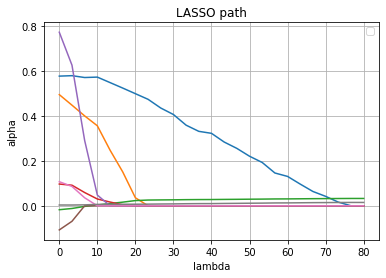

[ 0.          3.33333333  6.66666667 10.         13.33333333 16.66666667
 20.         23.33333333 26.66666667 30.         33.33333333 36.66666667
 40.         43.33333333 46.66666667 50.         53.33333333 56.66666667
 60.         63.33333333 66.66666667 70.         73.33333333 76.66666667
 80.        ]


In [207]:
plot_LASSO_path(LASSO_PATH,LAM)